In [9]:
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:

symbol = "sh.600000"
start_date = '2022-07-01'
end_date = '2024-12-31'
frequency = "d"

datapath = os.path.join(os.getcwd(),"data")
dataname = os.path.join(datapath,"{}_{}-{}-{}_history_A_stock_k_data.csv".format(symbol,start_date,frequency,end_date))
lg = bs.login()
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

rs = bs.query_history_k_data_plus(symbol,
    "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
    start_date=start_date, end_date=end_date,
    frequency=frequency, adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)

data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

if not os.path.isdir(datapath):
    os.mkdir(datapath)
result.to_csv(dataname, index=False)
print(result)
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
           date       code     open     high      low    close preclose  \
0    2022-07-01  sh.600000   8.0100   8.0400   7.9800   7.9900   8.0100   
1    2022-07-04  sh.600000   7.9900   8.0000   7.9400   7.9600   7.9900   
2    2022-07-05  sh.600000   7.9600   8.0000   7.9400   7.9800   7.9600   
3    2022-07-06  sh.600000   7.9700   7.9800   7.8700   7.9000   7.9800   
4    2022-07-07  sh.600000   7.8800   7.9200   7.8600   7.8700   7.9000   
..          ...        ...      ...      ...      ...      ...      ...   
604  2024-12-25  sh.600000  10.1300  10.3900  10.1300  10.3500  10.1300   
605  2024-12-26  sh.600000  10.3500  10.3900  10.1600  10.3400  10.3500   
606  2024-12-27  sh.600000  10.3300  10.3900  10.1200  10.3600  10.3400   
607  2024-12-30  sh.600000  10.3400  10.4900  10.3100  10.4700  10.3600   


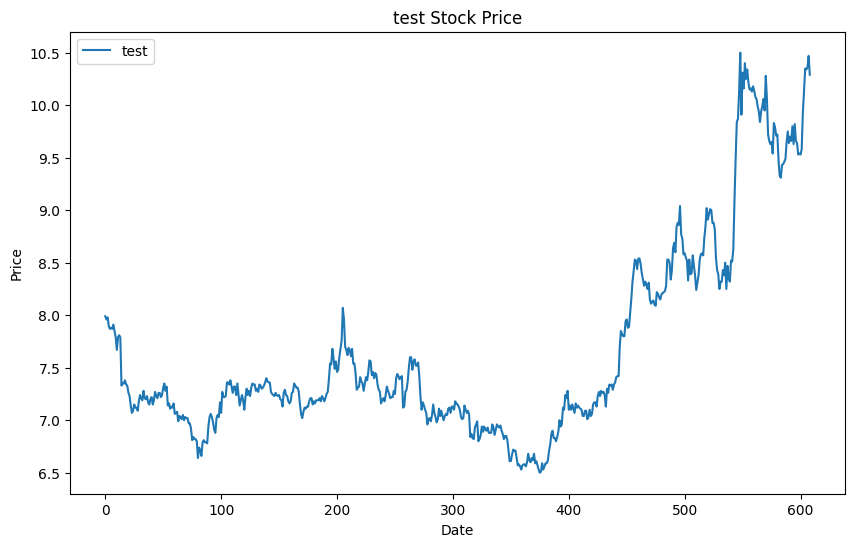

In [11]:
data = pd.read_csv(dataname)
data.head()
data['close'].plot(figsize=(10, 6), label="test")
plt.title("test Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [12]:
data['MA_50'] = data['close'].rolling(window=50).mean()
data['MA_200'] = data['close'].rolling(window=200).mean()

data['signal'] = 0
# data['signal'][data['MA_50'] > data['MA_200']] = 1
# data['signal'][data['MA_50'] < data['MA_200']] = -1
data.loc[data['MA_50'] > data['MA_200'], 'signal'] = 1
data.loc[data['MA_50'] < data['MA_200'], 'signal'] = -1
data["RETURN_DAY"] = data['close'].pct_change()
data["Strategy_Return"] = data["RETURN_DAY"] * data['signal'].shift(1)
data["cumprofit"] = (1 + data['Strategy_Return']).cumprod()


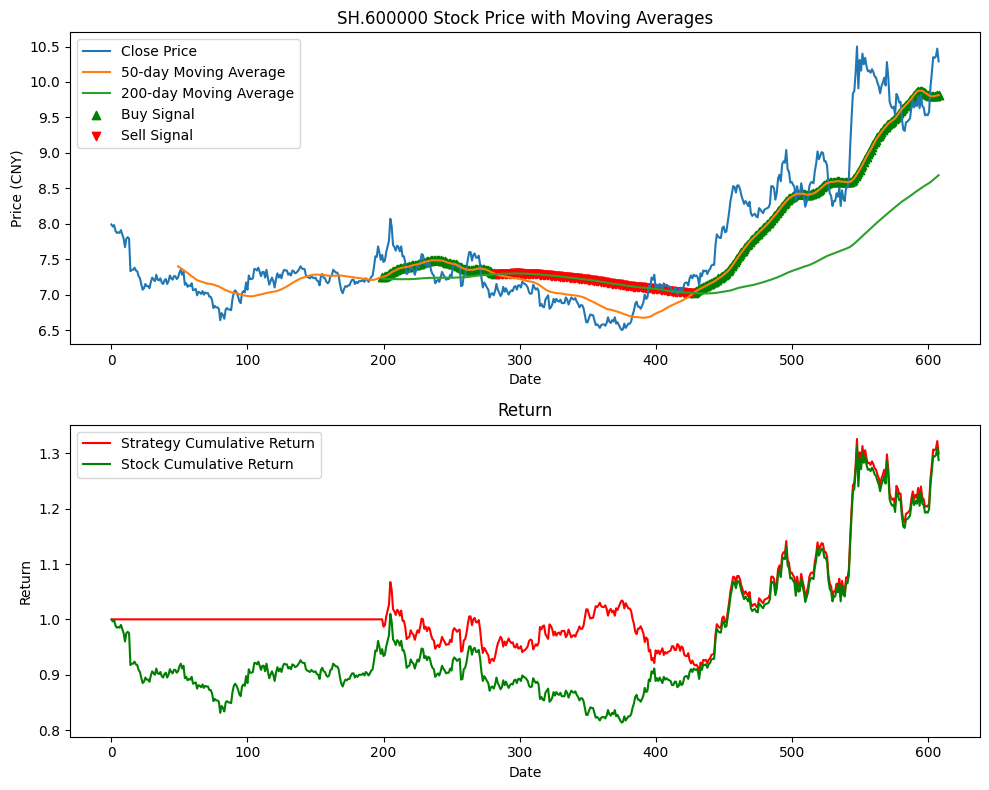

In [18]:

plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(data['close'], label='Close Price')
plt.plot(data['MA_50'], label='50-day Moving Average')
plt.plot(data['MA_200'], label='200-day Moving Average')

plt.scatter(data[data['signal'] == 1].index,data[data['signal'] == 1]['MA_50'], marker='^', color='g', label='Buy Signal')
plt.scatter(data[data['signal'] == -1].index,data[data['signal'] == -1]['MA_200'], marker='v', color='r', label='Sell Signal')
plt.title("SH.600000 Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (CNY)")
plt.legend()

plt.subplot(212)
plt.plot(data['cumprofit'], label='Strategy Cumulative Return', color='r')
plt.plot(data['close'] / data['close'].iloc[0], label='Stock Cumulative Return', color='g')
plt.title("Return")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

figurepath = os.path.join(os.getcwd(),"figures")
if not os.path.isdir(figurepath):
    os.mkdir(figurepath)

plt.tight_layout()
plt.savefig(os.path.join(figurepath,"Rolling-Average.png"), dpi=300, bbox_inches='tight')
plt.show()